C:\Users\Marit van Megesen\AppData\Local\Temp\ipykernel_57744\2896643079.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  Concentration[indix,indiy,indiz] =((emission_rate/(2*math.pi*windspeed*sig_y[indix,indiy,indiz]*sig_z[indix,indiy,indiz]))*(math.e**(-crosswind[indix,indiy,indiz]**2/(2*sig_y[indix,indiy,indiz]**2))* (math.e**(-(Z[indix,indiy,indiz]-stack_height)**2/(2*sig_z[indix,indiy,indiz]**2))+ math.e**(-(Z[indix,indiy,indiz]+stack_height)**2/(2*sig_z[indix,indiy,indiz]**2)))))


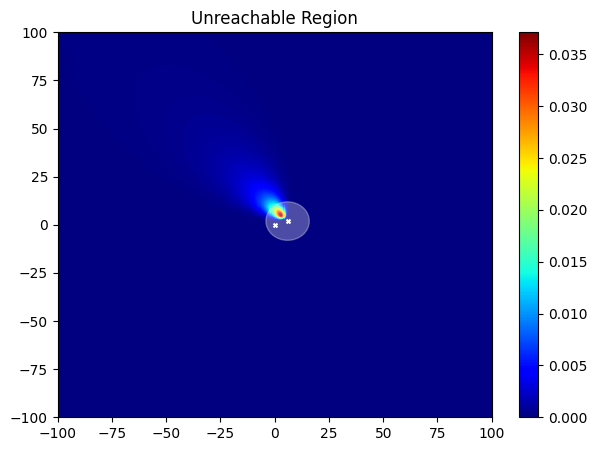

In [33]:
from scipy.ndimage import rotate, shift
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import scipy.stats as sp
import pandas as pd
import statsmodels.api as sm
import math
import cmath
import seaborn as sns

#INPUT FOR GAS PLUME
# np.random.seed(32)
#set from 1-6
stability = 1                                                                                      
#Origin Coordinates Of Plume
angle= np.random.uniform(0, 2 * np.pi)
stack_x = np.random.uniform(0, 51) * np.cos(angle)
stack_y = np.random.uniform(0, 51) * np.sin(angle)
stack_height = np.random.randint(1,11) 
emission_rate = np.random.randint(1,21)                                                                 
windspeed= np.random.randint(1,26)
#Wind Angle In Degrees
wind_direction= np.random.uniform(0, 2 * np.pi)

#INPUT FOR ALGORITHM

#Input For Coordinates Of Initial Measurement Point Of Robot (Can Start Out With Multiple)
Measurement_Points=[[0,0]] 

#GRID & STEPSIZE CALCULATION 

x_range=np.arange(-100,100,0.5)
y_range=np.arange(-100,100,0.5)
z_range=np.arange(0,50,0.5)
#It Turns Each Into 3D-Arrays For Calculations In All 3 Axis
X,Y,Z = np.meshgrid(x_range,y_range,z_range)

#WIND RELATED CALCULATIONS

#For Future (height_slice_direction= math.atan2(measured_y - stack_y, measured_x - stack_x) *(180/(math.pi)))
#3D-Arrays For Distance Between Coordinate & Origin
x_origin=X-stack_x
y_origin=Y-stack_y

wind_xcomponent=windspeed*math.sin(wind_direction-np.pi)
wind_ycomponent=windspeed*math.cos(wind_direction-np.pi)

dot_product=wind_xcomponent*x_origin+wind_ycomponent*y_origin
magnitudes= windspeed*((x_origin**2)+(y_origin**2))**0.5
subtended=np.arccos(dot_product/(magnitudes))
hypotenuse=((x_origin**2)+(y_origin**2))**0.5
#Downwind Is X Of Gaussian Plume Formula 
downwind=np.cos(subtended)*hypotenuse
#Turns It Into Complex Format To Make Correct Calculations Later On.
downwindimag=np.vectorize(complex)(downwind.real, downwind.imag)

#PASQUILL CONSTANTS & SIGMA CALCULATION

#Pasquill Constants Found In Resources
stability_class= {1 : (122.8,0.94470,24.1670,2.5334),
                  2: (90.673, 0.93198, 18.3330, 1.8096),
                  3: (61.141, 0.91465, 12.5, 1.0857),
                  4: (34.459, 0.86974, 8.3330, 0.72382),
                  5: (24.26, 0.83660, 6.25, 0.54287),
                  6: (15.209, 0.81558, 4.1667, 0.36191)
                 }
P_a=stability_class[stability][0] 
P_b=stability_class[stability][1]
P_c=stability_class[stability][2]
P_d=stability_class[stability][3]
sig_z = P_a*(abs((downwind/1000))**P_b)
sig_z[sig_z > 5000] = 5000
theta=0.017453293*(P_c-P_d*np.log((downwindimag/1000)))
sig_y=(465.11628*downwind/1000)*np.tan(theta)

#CROSSWIND AND GAUSSIAN FORMULA

crosswind=np.sin(subtended)*hypotenuse
indix,indiy,indiz=np.where((downwind > 0))
Concentration= np.zeros(np.shape(downwind))
Concentration[indix,indiy,indiz] =((emission_rate/(2*math.pi*windspeed*sig_y[indix,indiy,indiz]*sig_z[indix,indiy,indiz]))*(math.e**(-crosswind[indix,indiy,indiz]**2/(2*sig_y[indix,indiy,indiz]**2))* (math.e**(-(Z[indix,indiy,indiz]-stack_height)**2/(2*sig_z[indix,indiy,indiz]**2))+ math.e**(-(Z[indix,indiy,indiz]+stack_height)**2/(2*sig_z[indix,indiy,indiz]**2)))))
#Prevents Issues Regarding Algorithm And Measurements
Concentration[Concentration < 3e-5] = 0
Concentration2D=(Concentration[:,:, 0])

#SETUP FOR INTERACTIVE PLOT

#plt.ion Allows For The Continuously Updated Plot 
plt.ion()
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlim([-100, 100])
ax.set_ylim([-100, 100])
#Heatmap
#plt.contour(x_range, y_range, Concentration2D,cmap='summer',s=3)

#CIRCLE
circle_radius = 10
circle_center = (np.clip(stack_x, -100 + circle_radius, 100 - circle_radius), np.clip(stack_y, -100 + circle_radius, 100 - circle_radius))
color_circle = "white" 
alpha_tran = 0.3
circle = plt.Circle(circle_center, circle_radius, color=color_circle, fill=True, alpha=alpha_tran)



plt.title('Unreachable Region')
plt.pcolor(x_range, y_range, Concentration2D, shading=None, cmap='jet')
plt.colorbar()

plt.gca().add_patch(circle)
ax.scatter(stack_x,stack_y,s=8,color='white',marker='x',label='Gas Leak Source')
ax.scatter(0,0,s=8,color= "white", marker = "x")
plt.ioff()
plt.show()